## Data Exploration

### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas
import geopandas.tools
from shapely.geometry import Point

### Load Data

In [3]:
df = pd.read_csv('~/Desktop/all_data.csv')

In [4]:
df.head(2)

,incident_num,category,description,day_of_week,indicent_date,incident_time,pd_district,resolution,address,x,y,location,pd_id,geometry,index_right,neighborhood_name
0,151101177.0,WARRANTS,WARRANT ARREST,Friday,2017-04-21,00:45:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711,-122.403404791479)",1.510000e+13,POINT (-122.4034048 37.77542071),33.0,South of Market
1,141091334.0,BURGLARY,"BURGLARY OF STORE, FORCIBLE ENTRY",Wednesday,2017-03-08,14:28:00,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711,-122.403404791479)",1.410000e+13,POINT (-122.4034048 37.77542071),33.0,South of Market


In [5]:
df['date_time'] = df['indicent_date'] + ' ' + df['incident_time']
df.head(2)

,incident_num,category,description,day_of_week,indicent_date,incident_time,pd_district,resolution,address,x,y,location,pd_id,geometry,index_right,neighborhood_name,date_time
0,151101177.0,WARRANTS,WARRANT ARREST,Friday,2017-04-21,00:45:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711,-122.403404791479)",1.510000e+13,POINT (-122.4034048 37.77542071),33.0,South of Market,2017-04-21 00:45:00
1,141091334.0,BURGLARY,"BURGLARY OF STORE, FORCIBLE ENTRY",Wednesday,2017-03-08,14:28:00,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711,-122.403404791479)",1.410000e+13,POINT (-122.4034048 37.77542071),33.0,South of Market,2017-03-08 14:28:00


In [3]:
df['date_time'] = df['date_time'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df['hour_of_day'] = [r.hour for r in df['date_time']]
df['month'] = df['date_time'].apply(lambda x: dt.datetime.strftime(x,'%b'))
df.drop(['indicent_date','incident_time'], axis=1, inplace=True)

In [4]:
def rename_categories(input_val):
    if input_val in ['SEX OFFENSES, FORCIBLE','SEX OFFENSES, NON FORCIBLE','ROBBERY','ASSAULT','KIDNAPPING','SUICIDE','EXTORTION','BRIBERY','MISSING PERSON']:
        return 'OFFENSES AGAINST THE PERSON'
    elif input_val in ['BAD CHECKS','EMBEZZLEMENT','FORGERY/COUNTERFEITING','FRAUD']:
        return 'WHITE COLLAR CRIME'
    elif input_val in ['LARCENY/THEFT','VEHICLE THEFT']:
        return 'THEFT'
    elif input_val in ['BURGLARY','ARSON','VANDALISM','STOLEN PROPERTY','TRESPASS']:
        return 'PROPERTY CRIME'
    elif input_val in ['DRUG/NARCOTIC','PROSTITUTION','GAMBLING','PORNOGRAPHY/OBSCENE MAT','DISORDERLY CONDUCT','DRUNKENNESS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS']:
        return 'SOCIAL ORDER OFFENSES'
    elif input_val == 'SECONDARY CODES':
        return 'DOMESTIC VIOLENCE AND JUVENILE CRIME'
    elif input_val in ['SUSPICIOUS OCC','LOITERING','TREA']:
        return 'SUSPICIOUS BEHAVIOR'
    elif input_val in ['RUNAWAY','FAMILY OFFENSES','RECOVERED VEHICLE','WEAPON LAWS','WARRANTS']:
        return 'OTHER OFFENSES'
    else:
        return input_val

df['broad_category'] = df['category'].apply(rename_categories)

In [5]:
df.head(2)

,incident_num,category,description,day_of_week,pd_district,resolution,address,x,y,location,pd_id,geometry,index_right,neighborhood_name,date_time,hour_of_day,month,broad_category
0,151101177.0,WARRANTS,WARRANT ARREST,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711,-122.403404791479)",1.510000e+13,POINT (-122.4034048 37.77542071),33.0,South of Market,2017-04-21 00:45:00,0,Apr,OTHER OFFENSES
1,141091334.0,BURGLARY,"BURGLARY OF STORE, FORCIBLE ENTRY",Wednesday,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711,-122.403404791479)",1.410000e+13,POINT (-122.4034048 37.77542071),33.0,South of Market,2017-03-08 14:28:00,14,Mar,PROPERTY CRIME


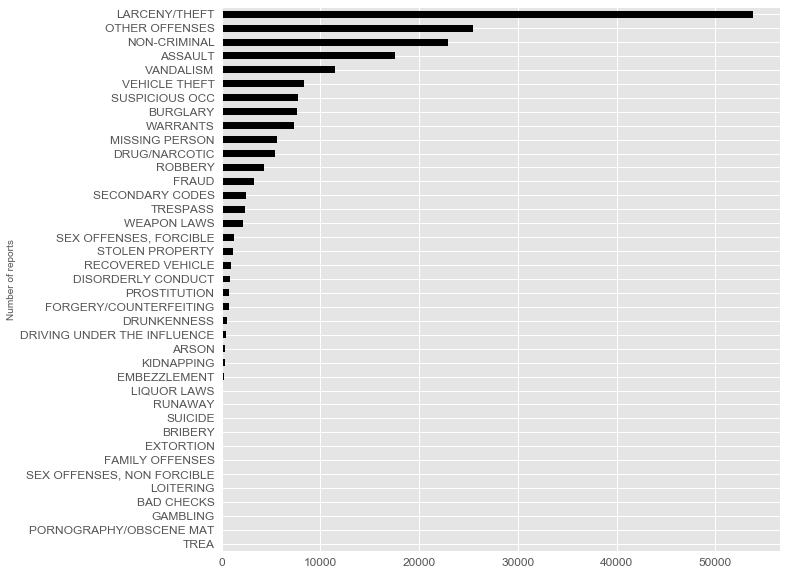

In [6]:
def plot_data(data, category):
    l = data.groupby(category).size().sort_values()
    fig = plt.figure(figsize=(10,10))
    plt.style.use('ggplot')
    plt.yticks(fontsize=8)
    l.plot(kind='barh',fontsize=12,color='k')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

plot_data(df,'category')

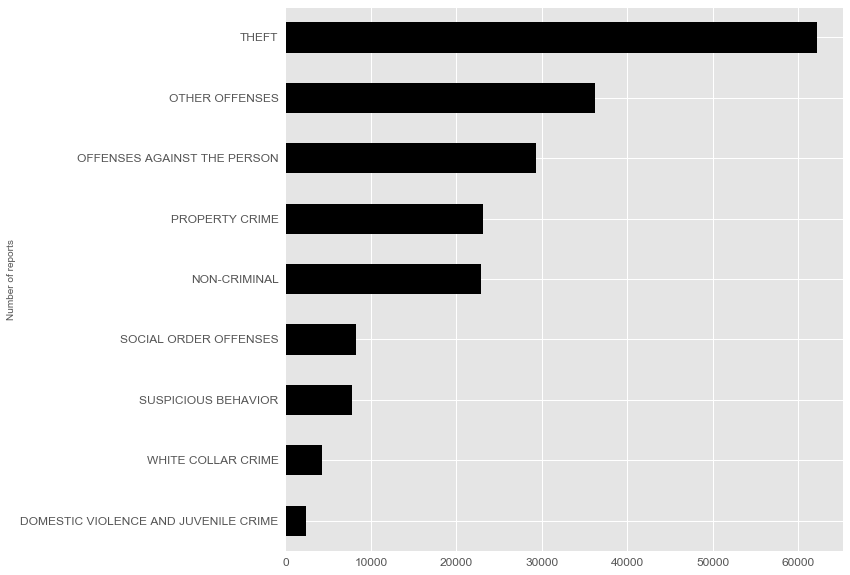

In [7]:
plot_data(df,'broad_category')

In [8]:
def types_nhoods(df, per):
    
    # Group by crime type and district 
    hoods_per_type = df.groupby('broad_category').neighborhood_name.value_counts(sort=True)
    t = hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum = t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t = t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum = t.sum(axis=1)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p = np.percentile(crime_sum, per)
    ix = crime_sum[crime_sum > p]
    t = t.loc[ix.index]
    return t
    
t=types_nhoods(df,96)

In [9]:
nhood_crimes = df.groupby('broad_category')['neighborhood_name'].value_counts()
nhood_crimes = nhood_crimes.unstack().fillna(0)
nhood_totals = nhood_crimes.sum(axis=0).sort_values(ascending=False)
nhood_crimes = nhood_crimes[nhood_totals.index]
crime_totals = nhood_crimes.sum(axis=1).sort_values(ascending=False)
crime_totals

broad_category
THEFT                                   62144.0
OTHER OFFENSES                          36203.0
OFFENSES AGAINST THE PERSON             29253.0
PROPERTY CRIME                          23089.0
NON-CRIMINAL                            22921.0
SOCIAL ORDER OFFENSES                    8229.0
SUSPICIOUS BEHAVIOR                      7807.0
WHITE COLLAR CRIME                       4306.0
DOMESTIC VIOLENCE AND JUVENILE CRIME     2456.0
dtype: float64

/Users/matthewmurray/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

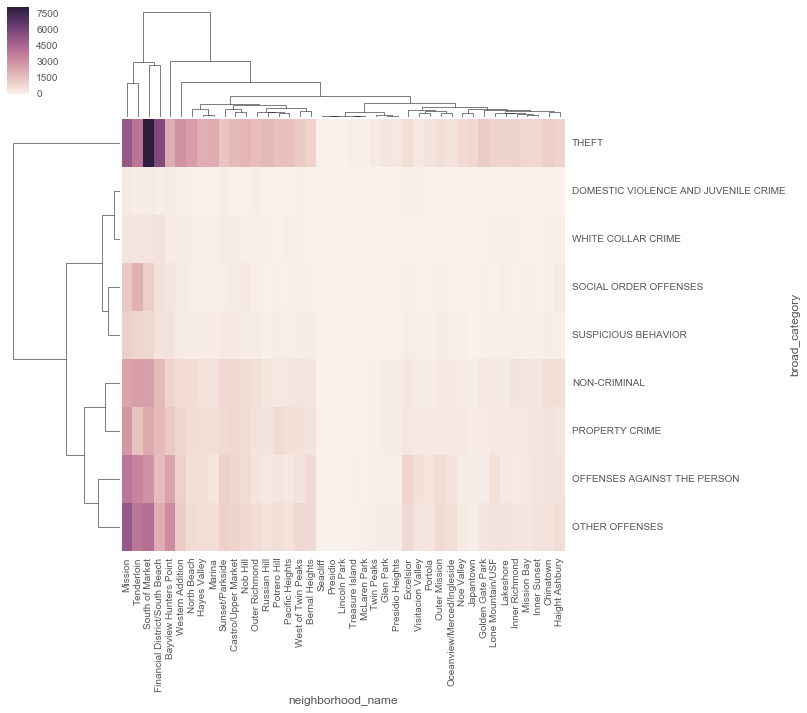

In [10]:
cg = sns.clustermap(nhood_crimes)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)

In [11]:
sf = geopandas.read_file('sf.geojson')
sf.crs = {'init': 'epsg:4326'}
sf.head()

,geometry,nhood
0,(POLYGON ((-122.3815777424142 37.7530704309124...,Bayview Hunters Point
1,(POLYGON ((-122.403612999828 37.74933700015653...,Bernal Heights
2,(POLYGON ((-122.4265550005568 37.7694849998470...,Castro/Upper Market
3,(POLYGON ((-122.4062259995664 37.7975590002937...,Chinatown
4,(POLYGON ((-122.4239820002333 37.7315519997551...,Excelsior


In [12]:
categories = list(df['broad_category'].unique())
categories

['OTHER OFFENSES',
 'PROPERTY CRIME',
 'THEFT',
 'NON-CRIMINAL',
 'OFFENSES AGAINST THE PERSON',
 'DOMESTIC VIOLENCE AND JUVENILE CRIME',
 'SOCIAL ORDER OFFENSES',
 'SUSPICIOUS BEHAVIOR',
 'WHITE COLLAR CRIME']

In [13]:
geo_df = geopandas.GeoDataFrame(df)
geo_df.head(1)

,incident_num,category,description,day_of_week,pd_district,resolution,address,x,y,location,pd_id,geometry,index_right,neighborhood_name,date_time,hour_of_day,month,broad_category
0,151101177.0,WARRANTS,WARRANT ARREST,Friday,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711,-122.403404791479)",1.510000e+13,POINT (-122.4034048 37.77542071),33.0,South of Market,2017-04-21 00:45:00,0,Apr,OTHER OFFENSES


In [14]:
geo_df = geo_df[['neighborhood_name','broad_category','y','x']]
geo_df.head(2)

,neighborhood_name,broad_category,y,x
0,South of Market,OTHER OFFENSES,37.775421,-122.403405
1,South of Market,PROPERTY CRIME,37.775421,-122.403405


In [15]:
# for cat in categories:
#     geo_df = geopandas.GeoDataFrame(geo_df[geo_df['broad_category'] == cat])
#     geo_df['geometry'] = geo_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
#     geo_df.drop(['x','y'], axis=1, inplace=True)
#     geo_df.crs = {'init': 'epsg:4326'}
    
#     fig, ax = plt.subplots(1, figsize=(13,10))
#     sf_map = sf.plot(ax=ax, color='gray')
#     geo_df.plot(ax=sf_map, marker="o", mfc="red", markersize=8, markeredgecolor="black", alpha=0.3)
#     ax.set_title(cat)
#     plt.show()

In [ ]:
geo_df = geopandas.GeoDataFrame(df[df['broad_category'] == 'THEFT'].sample(5000))
geo_df['geometry'] = geo_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
geo_df.drop(['x','y'], axis=1, inplace=True)
geo_df.crs = {'init': 'epsg:4326'}
    
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
geo_df.plot(ax=sf_map, marker="o", mfc="red", markersize=5, markeredgecolor="black", alpha=0.2)
ax.set_title('THEFT')
plt.show()

In [ ]:
geo_df = geopandas.GeoDataFrame(df[df['broad_category'] == 'PROPERTY CRIME'])
geo_df['geometry'] = geo_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
geo_df.drop(['x','y'], axis=1, inplace=True)
geo_df.crs = {'init': 'epsg:4326'}
    
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
geo_df.plot(ax=sf_map, marker="o", mfc="red", markersize=5, markeredgecolor="black", alpha=0.2)
ax.set_title('PROPERTY CRIME')
plt.show()

In [ ]:
geo_df = geopandas.GeoDataFrame(df[df['broad_category'] == 'OFFENSES AGAINST THE PERSON'])
geo_df['geometry'] = geo_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
geo_df.drop(['x','y'], axis=1, inplace=True)
geo_df.crs = {'init': 'epsg:4326'}
    
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
geo_df.plot(ax=sf_map, marker="o", mfc="red", markersize=5, markeredgecolor="black", alpha=0.2)
ax.set_title('OFFENSES AGAINST THE PERSON')
plt.show()

In [ ]:
geo_df = geopandas.GeoDataFrame(df[df['broad_category'] == 'SOCIAL ORDER OFFENSES'])
geo_df['geometry'] = geo_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
geo_df.drop(['x','y'], axis=1, inplace=True)
geo_df.crs = {'init': 'epsg:4326'}
    
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
geo_df.plot(ax=sf_map, marker="o", mfc="red", markersize=5, markeredgecolor="black", alpha=0.2)
ax.set_title('SOCIAL ORDER OFFENSES')
plt.show()

In [ ]:
geo_df = geopandas.GeoDataFrame(df[df['category'] == 'BURGLARY'])
geo_df['geometry'] = geo_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
geo_df.drop(['x','y'], axis=1, inplace=True)
geo_df.crs = {'init': 'epsg:4326'}
    
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
geo_df.plot(ax=sf_map, marker="o", mfc="red", markersize=5, markeredgecolor="black", alpha=0.2)
ax.set_title('BURGLARY')
plt.show()

In [ ]:
geo_df = geopandas.GeoDataFrame(df[df['broad_category'] == 'DOMESTIC VIOLENCE AND JUVENILE CRIME'])
geo_df['geometry'] = geo_df.apply(lambda row: Point(row['x'], row['y']), axis=1)
geo_df.drop(['x','y'], axis=1, inplace=True)
geo_df.crs = {'init': 'epsg:4326'}
    
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='gray')
geo_df.plot(ax=sf_map, marker="o", mfc="red", markersize=5, markeredgecolor="black", alpha=0.2)
ax.set_title('DOMESTIC VIOLENCE AND JUVENILE CRIME')
plt.show()

In [ ]:
df['address'].sample(40)